In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
rng = np.random.default_rng()
from scipy.optimize import curve_fit

## FUNCTIONS ##

In [3]:
def euler_step_2D(psi):
    # evolves the wavefunction psi (Nx x Ny array) one timestep
    # Scalar variables defined globally:
        # hbar: \hbar
        # g: Coupling constant
        # m: Mass of a single particle
        # Nx, Ny: Number of points in the x,y axis
        # kb: Boltzmann consntant
        # gamma: Dissipation rate
        # T: Temperature
        # k_cut: Maximum momentum included in the projection
        # N_coh: Number of coherent particles
    # Array variables defined globally:
        # Kdos : Kx^2 + Ky^2 (Nx x Ny array)
        # V : External potential (Nx x Ny array)
        # mask : Boolean mask to apply the projector in momentum space

    # FFT of the wavefunction psi
    psi_k = fft.fft2(psi)
    # Laplacian calculated in momentum space
    d2psi_d2 = fft.ifft2(-Kdos * psi_k)
    # Kinetic term of the equation
    H_k = -0.5 * (hbar**2 / m) * d2psi_d2
    # Interaction term of the equation
    H_V= (V+ g*(np.abs(psi)**2))*psi    
    # Total effective Hamiltonian of the equation
    H_tot = H_k + H_V
    # Real component of the stochastic noise
    noise_real = rng.normal(loc=0, scale= 1, size= (Nx,Ny))
    # Imaginary component of the stochastic noise
    noise_im = rng.normal(loc=0, scale= 1, size= (Nx, Ny))
    # Noise computed with the correct variance
    noise = np.sqrt((hbar*kb*gamma*T)/(dy*dx*dt))*(noise_real + 1j*noise_im)
    # Timestep
    psi += -(1j*dt/hbar)*(H_tot)*(1 -1j*gamma)
    psi += -(1j*dt/hbar)*noise
    # FFT of the resulting wavefunction to apply the mask (projector onto highly ocuppated modes)
    psi_k_unmasked = fft.fft2(psi)
    k_magnitude = np.sqrt(Kdos)
    mask = k_magnitude <= k_cut
    psi_masked = fft.ifft2(psi_k_unmasked * mask)
    # Normalization to the number og coherent particles
    psi_masked *= np.sqrt(N_coh/np.trapezoid(np.trapezoid(np.abs(psi_masked)**2,y, axis=0), x))
    # Returns the wavefunction evolved and projected
    return psi_masked

def euler_step_2D_m(psi, mask):
    psi_k = fft.fft2(psi)
    d2psi_d2 = fft.ifft2(-Kdos * psi_k)
    H_k = -0.5 * (hbar**2 / m) * d2psi_d2
    H_V= (V+ g*(np.abs(psi)**2))*psi                    
    H_tot = H_k + H_V
    noise_real = rng.normal(loc=0, scale= 1, size= (Nx,Ny))
    noise_im = rng.normal(loc=0, scale= 1, size= (Nx, Ny))
    noise = np.sqrt((hbar*kb*gamma*T)/(dy*dx*dt))*(noise_real + 1j*noise_im)
    psi += -(1j*dt/hbar)*(H_tot)*(1 -1j*gamma)
    psi += -(1j*dt/hbar)*noise
    psi_k_unmasked = fft.fft2(psi)
    psi_masked = fft.ifft2(psi_k_unmasked * mask)
    psi_masked *= np.sqrt(N_coh/np.trapezoid(np.trapezoid(np.abs(psi_masked)**2,y, axis=0), x))
    return psi_masked

def derivada_psi(psi):
    psi_k = fft.fft2(psi)
    # dpsi_dx = fft.ifft(1j*KX * psi_k)
    d2psi_d2 = fft.ifft2(-Kdos * psi_k)
    H_k = -0.5 * (hbar**2 / m) * d2psi_d2
    H_V= (V+ g*(np.abs(psi)**2))*psi   
    # H_sf = 1j*hbar*dpsi_dx*v_x
    H_tot = H_k + H_V
    noise_real = rng.normal(loc=0, scale= 1, size= (Nx,Ny))
    noise_im = rng.normal(loc=0, scale= 1, size= (Nx, Ny))
    noise = np.sqrt((hbar*kb*gamma*T)/(dy*dx*dt))*(noise_real + 1j*noise_im)
    rk4_der = -(1j/hbar)*(H_tot)*(1 -1j*gamma)
    rk4_der = -(1j/hbar)*noise
    return rk4_der

def rk4_step_2D(psi):
    k1 = derivada_psi(psi)
    k2 = derivada_psi(psi + 0.5 * dt * k1)
    k3 = derivada_psi(psi + 0.5 * dt * k2)
    k4 = derivada_psi(psi + dt * k3)
    psi += dt* (k1 + 2.0 * k2 + 2.0 * k3 + k4)/6
    psi_k_unmasked = fft.fft2(psi)
    k_magnitude = np.sqrt(Kdos)
    mask = k_magnitude <= k_cut
    psi_masked = fft.ifft2(psi_k_unmasked * mask)
    psi_masked *= np.sqrt(N_coh/np.trapezoid(np.trapezoid(np.abs(psi_masked)**2,y, axis=0), x))
    return psi_masked 

import numpy as np

def detect_vortices(phase_array):
    """
    Detecta vórtices y antivórtices en un arreglo 2D de fases calculando la circulación
    alrededor de celdas 2x2. Un vórtice tiene una circulación ~ 2π,
    un antivórtice ~ -2π.

    Args:
        phase_array (np.ndarray): Arreglo 2D con valores de fase en radianes [-π, π)

    Returns:
        tuple: (vortices, num_vortices, antivortices, num_antivortices)
    """
    phase_array = np.array(phase_array)
    rows, cols = phase_array.shape
    vortices = []
    antivortices = []

    def phase_diff(a, b):
        """Calcula la diferencia de fase desempaquetada entre a y b"""
        return np.angle(np.exp(1j * (a - b)))

    # Recorre cada celda 2x2
    for i in range(rows - 1):
        for j in range(cols - 1):
            phi0 = phase_array[i, j]       # esquina superior izquierda
            phi1 = phase_array[i, j + 1]   # esquina superior derecha
            phi2 = phase_array[i + 1, j + 1] # esquina inferior derecha
            phi3 = phase_array[i + 1, j]   # esquina inferior izquierda

            # Circulación en sentido antihorario
            dphi1 = phase_diff(phi1, phi0)
            dphi2 = phase_diff(phi2, phi1)
            dphi3 = phase_diff(phi3, phi2)
            dphi4 = phase_diff(phi0, phi3)

            total_phase = dphi1 + dphi2 + dphi3 + dphi4

            # Clasificación según la circulación total
            if np.isclose(total_phase, 2 * np.pi, atol=0.1):
                vortices.append((i + 0.5, j + 0.5))
            elif np.isclose(total_phase, -2 * np.pi, atol=0.1):
                antivortices.append((i + 0.5, j + 0.5))

    return vortices, len(vortices), antivortices, len(antivortices)

def energy_2D(psi):
    psi_k = fft.fft2(psi)
    psi4= np.abs(psi)**4
    psi_conj = np.conjugate(psi)
    d2psi_d2 = fft.ifft2(-Kdos * psi_k)
    op_kin = -hbar**2/(2*m)*d2psi_d2
    E_k = psi_conj*op_kin
    E_g= g/2*psi4
    energy= np.trapezoid(np.trapezoid(E_k + E_g ,y, axis=0), x)
    return np.real(energy)

def E_kin(psi):
    psi_k = fft.fft2(psi)
    psi_conj = np.conjugate(psi)
    d2psi_d2 = fft.ifft2(-Kdos * psi_k)
    op_kin = -hbar**2/(2*m)*d2psi_d2
    kin_integrand = psi_conj*op_kin
    kinetic = np.trapezoid(np.trapezoid(kin_integrand, y, axis=0), x)
    return np.real(kinetic)

def fo_corr_func(psi_ensemble):
    g1_array = []
    
    for psi in psi_ensemble:
 
        psi_fft = np.fft.fft2(psi)
        power_spectrum = np.abs(psi_fft)**2
        
        corr = np.fft.ifft2(power_spectrum)
        corr = np.fft.fftshift(corr)  # Centrar en r=0
        
        g1 = np.abs(corr)

        g1_array.append(g1/n0)
        
    g1_total = np.mean(g1_array, axis=0)
    
    stack = np.stack((R/Rmax, g1_total), axis=-1)
    joint = np.apply_along_axis(lambda x: list(x), -1, stack) 
    r_list = joint[:, :, 0].flatten()
    g1_list = joint[:, :, 1].flatten()

    return r_list, g1_list

def fo_corr_func1(psi_ensemble, nbins):
    # Calculates g1 
    # Arguments:
        # psi_ensemble: array of wavefunctions (N x Nx x Ny)
        # nbins : number of bins to dicretize g1(r)

    # Scalar variables defined globally:
        # Rmax : defined as Rmax = R.max()

    # Array variables defined globally:
        # R : array constructed as R = np.sqrt(X^2 + Y^2)
        
    # Inicialize the array of g1s
    g1_array = []

    # calculates g1 for each realization in the ensemble
    # uses Wiener-Khinchin theorem 
    for psi in psi_ensemble:
        psi_fft = np.fft.fft2(psi)
        power_spectrum = np.abs(psi_fft)**2
        corr = np.real(np.fft.ifft2(power_spectrum))
        # normalization
        g1 = corr / corr[0,0]
        g1 = np.fft.fftshift(g1)
        g1_array.append(g1)
    # mean of the arrays    
    g1_total = np.mean(g1_array, axis=0)

    # flatten of radius and g1 arrays
    r_vals = (R / Rmax).flatten()
    g1_vals = g1_total.flatten()

    # radial bins to group the data 
    r_bins = np.linspace(0, np.max(r_vals), nbins + 1)
    r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    g1_binned = np.zeros(nbins)
    for i in range(nbins):
        mask = (r_vals >= r_bins[i]) & (r_vals < r_bins[i + 1])
        if np.any(mask):
            g1_binned[i] = np.mean(g1_vals[mask])
        else:
            g1_binned[i] = np.nan  # some bins can be empty due to the lack of points in the interval

    mask = np.isfinite(g1_binned)
    r_list = r_bin_centers[mask]
    g1_list = g1_binned[mask]

    return r_list, g1_list

def alfa_single(psi, lower, upper, nbins):
    # psi_ensemble: array with N equilibrated realizations of PSI

    #for a given ensemble calculates the stochastic mean of g1

    # calculates g1 for each realization in the ensemble
    # uses Wiener-Khinchin theorem 
    psi_fft = fft.fft2(psi)
    n_k = np.abs(psi_fft)**2
    g1 = fft.ifft2(n_k)
    g1 = fft.fftshift(g1)
    g1_abs = np.abs(g1)
    # normalization
    g1_abs = g1_abs / g1_abs[Nx//2, Ny//2]
    # flatten of radius and g1 arrays
    r_vals = R.flatten()
    g1_vals = g1_abs.flatten()

    # radial bins to group the data 
    r_bins = np.linspace(0, np.max(r_vals), nbins + 1)
    r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    g1_binned = np.zeros(nbins)
    for i in range(nbins):
        mask = (r_vals >= r_bins[i]) & (r_vals < r_bins[i + 1])
        if np.any(mask):
            g1_binned[i] = np.mean(g1_vals[mask])
        else:
            g1_binned[i] = np.nan  # some bins can be empty due to the lack of points in the interval

    mask = np.isfinite(g1_binned)
    r_list = r_bin_centers[mask]
    g1_list = g1_binned[mask]
    mask_fit = (r_list >= lower) & (r_list <= upper)
    r_red = r_list[mask_fit]
    g1_red = g1_list[mask_fit]
    ln_r = np.log(r_red)
    ln_g1 = np.log(g1_red)
    coefis = np.polyfit(ln_r, ln_g1, 1)  # coeffs = [m, b]
    alfa = -coefis[0]

    return alfa

## PHYSICAL PARAMETERS & MESH ##


In [5]:
hbar = 1.054571817e-34
kb = 1.380649e-23
L_exp = 20e-6
m = 1.4431e-25
# a0 = 5.291777e-11
# lz = 1e-6
# g = 4*np.pi*hbar**2*135*a0/m/lz
g = 0.53e-21*kb
# g1 = 9.5e-2*hbar**2/m
n0 = 9e12
xi = hbar/np.sqrt(2*n0*g*m)
T_BKT = 38e-9
N_tot = int(n0*L_exp**2)
gamma = 0.05
V = 0.0
print(N_tot)
g

3600


7.3174397e-45

In [7]:
# Parámetros malla
L_exp = 20e-6
dx = 20e-6/100
dy = dx
Lx = L_exp  # Longitud del dominio x
Ly = L_exp
N = int(L_exp/dx)
Nx = N
Ny = N
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X ,Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Rmax = R.max()
kx = fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Frecuencias en x
ky = fft.fftfreq(Ny, d=dy) * 2 * np.pi  # Frecuencias en y
KX, KY = np.meshgrid(kx, ky)  # Malla 2D de frecuencias
Kdos = KX**2 + KY**2
print(N)

100


In [9]:
(hbar**2/kb)*(2*np.pi*n0)/(m*np.log(380*hbar**2/(g*m)))

np.float64(3.8054129657701684e-08)

In [9]:
t_total = 0.3
dt = 0.25e-5
n_steps = int(t_total/dt)
n_steps

119999

## CUASICONDENSATE & VORTICES ##

In [11]:
%%time

gamma= 0.05
nqc_list = []
vortices_num = []
vortices_tot_num = []
V=0.0
N_tot = int(n0*L_exp**2)
T_arr = np.linspace(0, 2*T_BKT, 20)
for T in T_arr:
    vortices_num_single = []
    psis = []
    psis2 = []
    psis4 = []
    N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
    N_coh = N_tot - N_inc
    mu = g*N_coh/L_exp**2
    E_cut = kb*T*np.log(2) + mu
    k_cut = np.sqrt(E_cut*2*m/hbar**2)
    psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
    vortex_array = []
    vortex_tot_array = []
    timer = []
    for i in range(n_steps):
        if i%int(n_steps/10) == 0:
            print(i/n_steps)
        psi = euler_step_2D(psi)
        # fases_prueba = np.angle(psi)
        # vorticesp, num_vorticesp, antivorticesp, num_antivorticesp = detect_vortices(fases_prueba)
        # vortex_prueba.append(num_vorticesp + num_antivorticesp)
        # timer.append(i)
        if i >= int(0.7*n_steps):
            psi2 = np.abs(psi)**2
            psis2.append(psi2)
            psis4.append(psi2**2)
        if i >= int(n_steps-200):
            fases = np.angle(psi)
            vortices, num_vortices, antivortices, num_antivortices = detect_vortices(fases)
            vortex_tot_array.append(num_vortices + num_antivortices)
            vortex_array.append(num_vortices)
    psi2_mean = np.mean(psis2, axis =0)
    psi4_mean = np.mean(psis4, axis = 0)
    psis2_mean = psi2_mean.mean()
    psis4_mean = psi4_mean.mean()
    nqc = np.sqrt(2*(psis2_mean**2) - psis4_mean)/psis2_mean
    vortices_num.append(np.mean(vortex_array))
    vortices_tot_num.append(np.mean(vortex_tot_array))
    nqc_list.append(nqc)
    print(T, nqc, vortices_num[-1])
    # plt.plot(timer, vortex_prueba)
    # plt.show()

0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
0.0 1.0000000000004852 0.0
0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
4e-09 0.9924927849662067 0.0
0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
8e-09 0.9810610051798032 0.0
0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
1.2000000000000002e-08 0.9636956049508651 0.0
0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.399969999749997

In [27]:
datos = np.column_stack((T_arr, nqc_list))
np.savetxt('nqc_20mum_2.txt', datos, delimiter=' ')
datos = np.column_stack((T_arr, vortices_tot_num))
np.savetxt('vortex_20mum_2.txt', datos, delimiter=' ')

In [47]:
Temps, nqc_list = np.loadtxt("nqc_20mum.txt", unpack = True)
Temps1, vortices_num = np.loadtxt("vortex_20mum.txt", unpack = True)

In [ ]:
plt.plot(timer, vortex_prueba)
plt.xlabel("iterations")
plt.ylabel("number of vortex")
# plt.savefig("convergence_vortex_dt1e-5.png")
plt.show()

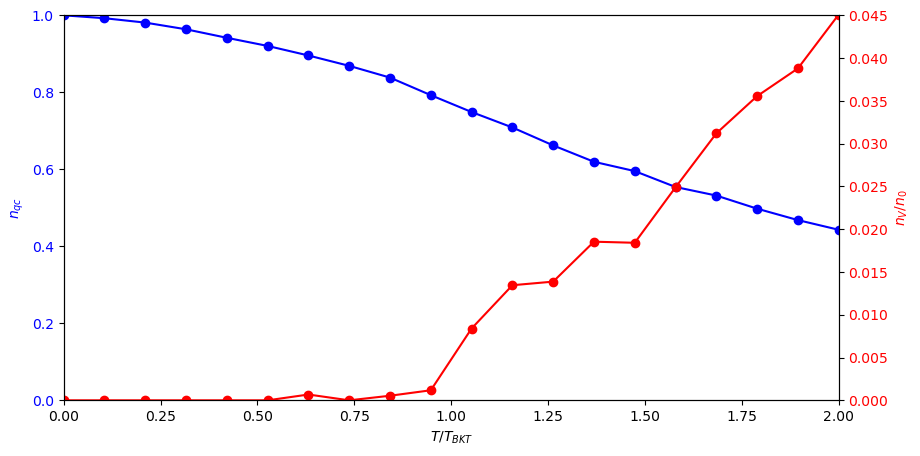

In [25]:
vortices_num = np.array(vortices_num)
vortices_tot_num = np.array(vortices_tot_num)
# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10,5))

# Plotear la primera curva (eje y izquierdo)
ax1.plot(T_arr/T_BKT, nqc_list, 'o-', color = "b")
ax1.set_xlabel(r'$T/T_{BKT}$')
ax1.set_ylabel(r'$n_{qc}$', color='b')
ax1.set_ylim(0,1)
ax1.set_xlim(0,2)
# ax1.set_xlim(0, 2)
ax1.tick_params(axis='y', labelcolor='b')
# ax1.axvline(x=1, color='black', linestyle='--')

# Crear el segundo eje y (comparte el eje x)
ax2 = ax1.twinx()

# Plotear la segunda curva (eje y derecho)
ax2.plot(T_arr/T_BKT, vortices_tot_num/N_tot, 'o-', color = "r") #divido entre 2, solo numero de vortices
# ax2.plot(Temps/T_BKT, vortices_tot_num/N_tot/2, "s-", color = "r")
ax2.set_ylabel(r'$n_V / n_0$', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 0.045)

# # Mostrar el gráfico
# # plt.savefig("replica_fig1_amelio.png")
plt.show()

### SNAPSHOTS ###

In [45]:
%%time

gamma= 0.05
V=0.0
T = 1.5*T_BKT
N_tot = int(n0*L_exp**2)
N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
N_coh = N_tot - N_inc
mu = g*(N_coh)/L_exp**2
E_cut = kb*T*np.log(2) + mu
k_cut = np.sqrt(E_cut*2*m/hbar**2)
psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
for i in range(n_steps):
    if i%3000 == 0:
        print(i/n_steps)
    psi = euler_step_2D(psi)
fases1 = np.angle(psi)
vortices1, num_vortices1, antivortices1, num_antivortices1 = detect_vortices(fases1)

0.0
0.025000208335069458
0.050000416670138915
0.07500062500520838
0.10000083334027783
0.12500104167534729
0.15000125001041675
0.17500145834548622
0.20000166668055566
0.22500187501562513
0.25000208335069457
0.27500229168576407
0.3000025000208335
0.32500270835590295
0.35000291669097244
0.3750031250260419
0.4000033333611113
0.4250035416961808
0.45000375003125026
0.4750039583663197
0.5000041667013891
0.5250043750364587
0.5500045833715281
0.5750047917065976
0.600005000041667
0.6250052083767365
0.6500054167118059
0.6750056250468754
0.7000058333819449
0.7250060417170143
0.7500062500520838
0.7750064583871532
0.8000066667222226
0.8250068750572922
0.8500070833923616
0.8750072917274311
0.9000075000625005
0.92500770839757
0.9500079167326394
0.975008125067709
CPU times: total: 22min 5s
Wall time: 22min 7s


In [49]:
np.savetxt('snapshot_psi_15TBKT_200.txt', fases1, fmt='%.3f', delimiter=',', header='Snapshot 0.9T_BKT')

In [ ]:
fases_40nK = np.loadtxt('snapshot_psi_40nK_256.txt', delimiter=',')

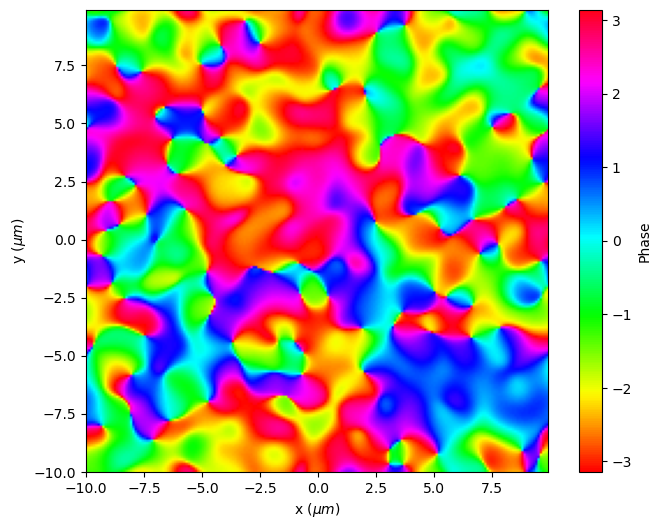

In [47]:
plt.figure(figsize = (8,6))
plt.imshow(fases1, cmap='hsv', extent=[x.min()/1e-6, x.max()/1e-6, y.min()/1e-6, y.max()/1e-6], origin='lower')
plt.colorbar(label='Phase')
plt.xlabel(r"x $(\mu m)$")
plt.ylabel(r"y $(\mu m)$")
plt.show()

In [ ]:
vortices3, num_vortices3, antivortices3, num_antivortices3 = detect_vortices(fases_40nK)

In [ ]:
print(vortices3)

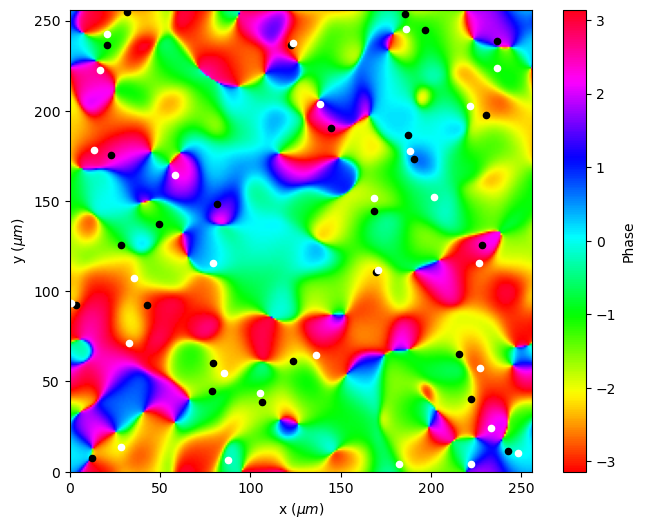

In [31]:
x_vortices, y_vortices = zip(*vortices)
x_antivortices, y_antivortices = zip(*antivortices)
plt.figure(figsize = (8,6))
plt.imshow(fases, cmap='hsv', extent=[0, fases.shape[1], 0, fases.shape[0]])
plt.colorbar(label='Phase')
plt.scatter(x_vortices, y_vortices, color='k', s=20, marker='o', label='Puntos')
plt.scatter(x_antivortices, y_antivortices, color='w', s=20, marker='o', label='Puntos')
plt.xlabel(r"x $(\mu m)$")
plt.ylabel(r"y $(\mu m)$")
plt.show()

## FIRST ORDER CORRELATION FUNCTION $g^{(1)}(r)$ ##

In [10]:
Ts = []
alfas = []

### Convergence test ###

In [11]:
%%time

gamma= 0.05
points = 4
start = 0.01*T_BKT
final = 1*T_BKT 
V=0.0
lower_bound = 0
upper_bound = 1
N_tot = int(n0*L_exp**2)
for T in np.linspace(start, final , points):
    T = 1.5*T_BKT
    N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
    N_coh = N_tot - N_inc
    print(N_coh)
    mu = g*N_coh/(L_exp**2)
    E_cut = kb*T*np.log(2) + mu
    k_cut = np.sqrt(E_cut*2*m/hbar**2)
    corr_funcs = []
    rads = []
    psi_ensemble = [0]
    alfas_p = []
    timer = []
    psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
    for i in range(n_steps):
        if i%int(n_steps/10) == 0:
            print(i/n_steps)
        psi = euler_step_2D(psi)
    psi_ensemble = [psi]
    r_snap, g1_snap = fo_corr_func1(psi_ensemble, 20)
    break

3150
0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
CPU times: total: 59.8 s
Wall time: 60 s


In [28]:
datos = np.column_stack((r_snap, g1_snap))
np.savetxt('g1_snap_15TBKT2.txt', datos, delimiter=' ')

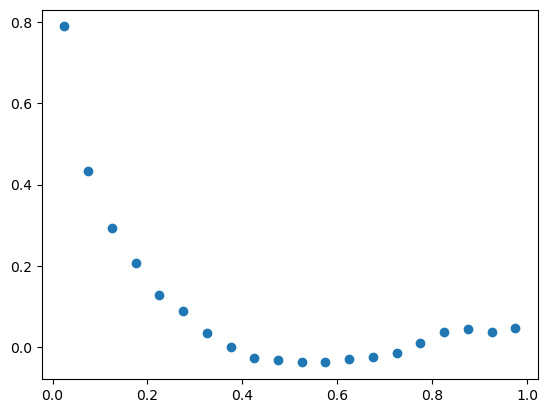

In [13]:
plt.plot(r_snap, g1_snap, "o")
plt.show()

### Evolution with T ###

In [24]:
%%time

# T_array = np.linspace(0, 1.3*T_BKT, 15)
T1 = np.linspace(0, 0.7*T_BKT, 5)
T2 = np.linspace(0.7*T_BKT, 1.3*T_BKT, 7)
T_array = np.unique(np.concatenate((T1,T2)))
alfa_arr1 = []
for T in T_array:
    alfa_it_arr = []
    # T = T_BKT
    N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
    N_coh = N_tot - N_inc
    mu = g*N_coh/(L_exp**2)
    E_cut = kb*T*np.log(2) + mu
    k_cut = np.sqrt(E_cut*2*m/hbar**2)
    for j in range(1):
        alfas_arr = []
        # timer = []
        psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
        for i in range(n_steps):
            if i%int(n_steps/10)==0:
                print(i/n_steps)
            psi = euler_step_2D(psi)
            if i>=int(0.6*n_steps):
                alfa_s = alfa_single(psi, 0.05*L_exp, 0.5*L_exp, 50)
                alfas_arr.append(alfa_s)
                # timer.append(i)
        alfa_it = np.mean(alfas_arr)
        print(alfa_it)
        alfa_it_arr.append(alfa_it)
    alfa = np.mean(alfa_it_arr)
    print(T, alfa)
    alfa_arr1.append(alfa)
    # plt.plot(timer, alfas_arr)
    # plt.show()
    # break

0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
0.0
0.0 0.0
0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
0.015742154956060617
6.65e-09 0.015742154956060617
0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
0.03233541809852942
1.33e-08 0.03233541809852942
0.0
0.09999249993749948
0.19998499987499896
0.29997749981249844
0.3999699997499979
0.4999624996874974
0.5999549996249969
0.6999474995624964
0.7999399994999958
0.8999324994374953
0.9999249993749948
0.05465380796979976
1.995e-08 0.05465380796979976
0.0
0.09999249993749948
0.19998499987499896
0.2999

In [58]:
datos3 = np.column_stack((T_array, alfa_arr1))
np.savetxt(f'g1_vs_T_def2.txt', datos3, delimiter=' ')

In [61]:
T_array , alfa_arr = np.loadtxt("g1_vs_T_def.txt", unpack = True)

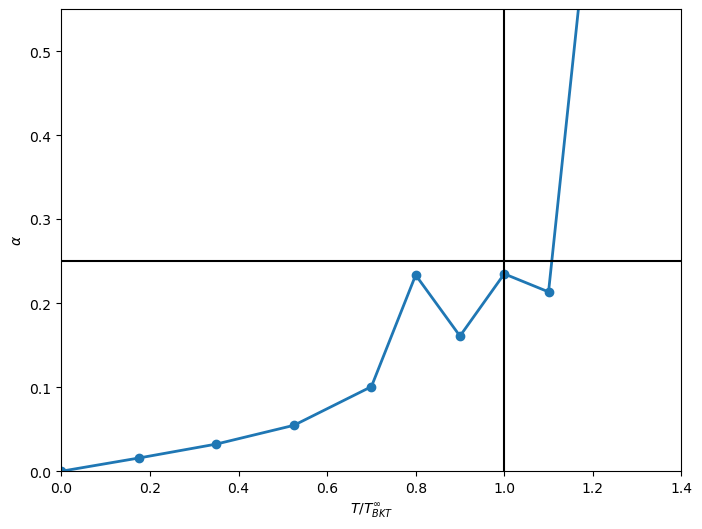

In [32]:
plt.figure(figsize=(8,6))
alfa_arr2 = np.mean(alfa_arr1, axis=0)
plt.plot(T_array/T_BKT, alfa_arr1, "o-", lw= 2)
plt.xlabel(r"$T/T_{BKT}^{\infty}$")
plt.axvline(x = 1, color = "k")
plt.axhline(y = 0.25, color = "k")
plt.ylabel(r"$\alpha$")
plt.ylim(0, 0.55)
plt.xlim(0,1.4)
# plt.savefig("alfa_vs_T.png", dpi=300)
plt.show()

In [ ]:
%%time

gamma= 0.05
V=0.0
lower_bound = 0.1
upper_bound = 0.6
T1 = np.linspace(10e-9, 29e-9, 6)
T2 = np.linspace(29e-9, 34e-9, 6)
T3 = np.linspace(34e-9, 40e-9, 4)
T_conc = np.unique(np.concatenate((T1, T2, T3)))
T_4 = np.linspace(25e-9, 1.2*T_BKT, 5)
for T in T_4:
    T = 0.9*T_BKT
    N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
    N_coh = N_tot - N_inc
    print(N_coh)
    mu = g*N_coh/(L_exp**2)
    E_cut = kb*T*np.log(2) + mu
    k_cut = np.sqrt(E_cut*2*m/hbar**2)
    corr_funcs = []
    rads = []
    psi_ensemble = []
    psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
    for i in range(n_steps):
        if i%5000==0:
            print(i/n_steps)
        psi = euler_step_2D(psi)
        if i>= int(0.7*n_steps):
            psi_ensemble.append(psi)
    r, g1 = fo_corr_func1(psi_ensemble,20)
    mask = (r >= lower_bound) & (r <= upper_bound)
    r_red = r[mask]
    g1_red = g1[mask]
    ln_r = np.log(r_red)
    ln_g1 = np.log(g1_red)
    plt.plot(ln_r, ln_g1, ".")
    coefis = np.polyfit(ln_r, ln_g1, 1)  # coeffs = [m, b]
    alfa = -1*coefis[0]
    alfas.append(alfa)
    Ts.append(T)
    print(T,alfa)
    x_t = np.linspace(ln_r.min(), ln_r.max(), 10)
    fit = coefis[0]*x_t + coefis[1]
    plt.plot(r_red, g1_red, "o-", ms = 5, label = "numerical", color = "k")
    plt.title(f"T= {T/1e-9:.3f}nK")
    r_t = np.linspace(0.01,1,100)
    fit_e = np.exp(coefis[1])*r_t**coefis[0]
    plt.plot(r_t, fit_e, label = "fit", color = "red")
    plt.xlim(0.1, 1)
    plt.ylim(0.95*g1.min(), 1.05*g1.max())
    plt.xlabel(r"$r/r_{max}$")
    plt.ylabel(r"$g^{(1)}(r)$")
    plt.legend()
    # plt.savefig(f"g1_{T/1e-9:.3f}nK.png")
    plt.show()
    datos = np.column_stack((r_red, g1_red))
    # np.savetxt(f'g1_{T/1e-9:.3f}nK.txt', datos, delimiter=' ')
    datos2 = np.column_stack((r_t, fit_e))
    # np.savetxt(f'g1_fit_{T/1e-9:.3f}nK.txt', datos2, delimiter=' ')
    break

### Fit Visualizer ###

In [60]:
mask = (r >= 0.05) & (r <= 0.5) & np.isfinite(g1)
r_red = r[mask]
g1_red = g1[mask]
plt.plot(r_red, g1_red.real, "o", ms = 5, label="numeric")
plt.xlabel(r"$r/r_{max}$")
plt.ylabel(r"$g^{(1)}(r)$")
plt.legend()
plt.show()

NameError: name 'r' is not defined

In [ ]:
ln_r = np.log(r_red)
ln_g1 = np.log(g1_red)
plt.plot(ln_r, ln_g1, ".")
coefis = np.polyfit(ln_r, ln_g1, 1)  # coeffs = [m, b]
alfa = -1*coefis[0]
x_t = np.linspace(ln_r.min(), ln_r.max(), 100)
fit = coefis[0]*x_t + coefis[1]
plt.plot(x_t, fit)
plt.show()
print(alfa)

In [ ]:
mask = (r >= 0.05) & (r <= 0.5)
r_red = r[mask]
g1_red = g1[mask]
plt.plot(r_red, g1_red, "o-", ms = 5, label = "numerical")
# plt.title(r"$T= T_{BKT}$")
r_t = np.linspace(0.01,1,100)
fit_e = np.exp(coefis[1])*r_t**coefis[0]
plt.plot(r_t, fit_e, label = "fit")
# plt.plot(r_means, g1_means, "o")
plt.xlim(0, 0.6)
plt.ylim(0.95*g1_red.min(),1.05*g1_red.max())
plt.xlabel(r"$r/r_{max}$")
plt.ylabel(r"$g^{(1)}(r)$")
plt.legend()
# plt.savefig("g1_fit_15T.png")
plt.show()

### $g^{(1)}(r)$ vs T ###

In [ ]:
datos3 = np.column_stack((Ts, alfas))
np.savetxt(f'g1_vs_T_N160_50mum.txt', datos3, delimiter=' ')

In [ ]:
Ts, alfas = np.loadtxt('g1_vs_T_N160_50mum.txt', unpack = True)
Ts1, alfas1 = np.loadtxt("g1_vs_T_64.txt", unpack = True)

In [ ]:
T_arr = np.array(Ts)
plt.figure(figsize = (8,6))
plt.plot(T_arr/1e-9, alfas, "o-", ms = 10, color = "k")
plt.axvline(x=32, color='r', linestyle='--', label = "32nK")
plt.axvline(x=38, color='r', linestyle='-.', label = "38nK")
plt.axhline(y=0.25, color='g', linestyle='--')
plt.ylim(0, 0.5)
plt.xlim(0, 45)
plt.xlabel(r"$T (nK)$")
plt.ylabel(r"$\alpha$")
plt.legend()
# plt.savefig("g1_vs_T_N160_40mum_plot.png")
plt.show()

In [ ]:
N_inc_arr = (L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T_arr).astype(int)
N_coh_arr = N_tot - N_inc_arr
n_coh_arr = N_coh_arr/L_exp**2
sf_arr = 1/(alfas*db_wl(T_arr)**2)/n_coh_arr
plt.figure(figsize = (8,6))
plt.plot(T_arr/1e-9, sf_arr, "-o")
plt.axvline(x=32, color='r', linestyle='--')
plt.axvline(x=38, color='r', linestyle='--')
plt.xlim(0,45)
plt.ylim(0,1)
plt.show()

### Coeficient evolution ###

In [ ]:
T_array = np.array(Ts)
plt.figure(figsize=(6,6))
plt.plot(T_array/T_BKT, alfas, "-o", label = r"$L=20\mu m$")
plt.xlabel(r"$T/T_{BKT}$")
plt.ylabel(r"$\alpha$")
plt.axvline(x = 1, color = "black")
plt.axhline(y = 0.25, color = "black")
plt.ylim(0,0.42)
plt.xlim(0,1.5)
plt.legend()
plt.savefig("g1corr_L20_9_5_24.png")
plt.show()

In [ ]:
datos = np.column_stack((T_array, alfas))
np.savetxt('g1corr_L20_9_5_24.txt', datos, delimiter=' ')

In [ ]:
%%time

gamma= 0.05
T_BKT = 32e-9
dt = 0.5e-5
n_steps = int(2e4)
points = 3
start = 20e-6
final = 50e-6
V=0.0
alfas = []
longs = []
n0 = 9e12
for L_exp in np.linspace(start, final , points):
    dx = 20e-6/100
    dy = dx
    N_tot = int(n0*L_exp**2)
    N = int(L_exp/dx)
    # N = 128
    Nx = N
    Ny = N
    Lx = L_exp  # Longitud del dominio x
    Ly = L_exp
    # dx = Lx/N
    # dy = Ly/N
    x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
    y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
    X ,Y = np.meshgrid(x, y)
    kx = fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Frecuencias en x
    ky = fft.fftfreq(Ny, d=dy) * 2 * np.pi  # Frecuencias en y
    KX, KY = np.meshgrid(kx, ky)  # Malla 2D de frecuencias
    Kdos = KX**2 + KY**2
    T = T_BKT
    N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
    N_coh = N_tot - N_inc
    print(N_coh)
    mu = g*N_coh/(L_exp**2)
    E_cut = kb*T*np.log(2) + mu
    k_cut = np.sqrt(E_cut*2*m/hbar**2)
    corr_funcs = []
    psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
    for i in range(n_steps):
        psi = euler_step_2D(psi)
        if i>=1500:
            r, g1 = fo_corr_func(psi)
            # plt.plot(r,g1)
            # plt.show()
            corr_funcs.append(g1)
    g1_mean = np.mean(corr_funcs, axis=0)
    # plt.plot(r,g1_mean)
    # plt.show()
    ln_r = np.log(r[1:])
    ln_g1 = np.log(g1_mean[1:])
    coefis = np.polyfit(ln_r, ln_g1, 1)  # coeffs = [m, b]
    alfa = -1*coefis[0]
    print(alfa)
    alfas.append(alfa)
    longs.append(L_exp)
    # break

In [ ]:
plt.plot(longs, alfas)

## EQUIPARTITION THEOREM ##

In [11]:
t_total = 0.25
dt = 0.2e-5
n_steps = int(t_total/dt)
n_steps

125000

In [15]:
%%time

gamma= 0.05
V=0.0
N_tot = int(n0*L_exp**2)
v_arr = []
E_arr = []
Ek_arr1 = []
E_equi_arr1 = []
E_equi_arr_an1 = []
T_arr = np.linspace(0*T_BKT, 2*T_BKT, 20)
for T in T_arr:
    # T = 1.5*T_BKT
    energy_recap = []
    ek_recap = []
    timer = []
    N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
    N_coh = N_tot - N_inc
    mu = g*(N_coh)/L_exp**2
    E_cut = kb*T*np.log(2) + mu
    k_cut = np.sqrt(E_cut*2*m/hbar**2)
    k_magnitude = np.sqrt(Kdos)
    mask = k_magnitude <= k_cut
    Nk_modes = np.count_nonzero(mask)
    Nk_modes_analytic = L_exp**2*k_cut**2/(4*np.pi)
    psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
    for i in range(n_steps):
        if i%int(n_steps/10) == 0:
            print(i/n_steps)
        psi = euler_step_2D_m(psi, mask)
        if i>=int(0.4*n_steps):
            timer.append(i)
            # E_psi = energy_2D(psi)
            # energy_recap.append(E_psi)
            Ek_psi = E_kin(psi)
            ek_recap.append(Ek_psi)
    # E_mean = np.mean(energy_recap)
    Ek_mean = np.mean(ek_recap)
    E_equi = Nk_modes*T*kb
    E_equi_anal = Nk_modes_analytic*T*kb
    # E_arr.append(E_mean)
    Ek_arr1.append(Ek_mean)
    E_equi_arr1.append(E_equi)
    E_equi_arr_an1.append(E_equi_anal)
    print(T, Ek_mean, E_equi, E_equi_anal)
    # break

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0 1.26536197062265e-46 0.0 0.0
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
4e-09 3.186927008054135e-30 4.9151104400000005e-30 4.724976934229401e-30
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
8e-09 9.32960054672208e-30 1.3364682320000004e-29 1.2889280707369003e-29
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.2000000000000002e-08 1.8124586153069934e-29 2.4023292600000006e-29 2.4495415051866546e-29
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.6e-08 2.912705045766163e-29 3.9099979680000003e-29 3.953920708030912e-29
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
2e-08 4.5089236058584405e-29 5.88156474e-29 5.80223259476619e-29
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
2.4000000000000003e-08 6.438090749107957e-29 7.985673816000001e-29 7.994977911882037e-29
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
2.8000000000000003e-08 9.207834766123163e-29 1.0708313644e-28 1.0531238624147612e-28
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
3.2e-08 1.1102850883913587e-28 1.2944965024000002e-28 1

In [13]:
T_arr_p, Ek_p, E_equi_p = np.loadtxt("equipartition.txt", unpack = True)

C:\Users\temis\AppData\Local\Temp\ipykernel_9200\2646050835.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(T_arr/T_BKT, Ek_arr1/(kb*T_arr), "o", ms = 8, color = "red", label = "Numerical")
C:\Users\temis\AppData\Local\Temp\ipykernel_9200\2646050835.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(T_arr/T_BKT, E_equi_arr1/(kb*T_arr), "s", ms = 8, color = "k", label = "Equipartition")
C:\Users\temis\AppData\Local\Temp\ipykernel_9200\2646050835.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(T_arr/T_BKT, E_equi_arr_an1/(kb*T_arr), "x", ms = 8, color = "k", label = "Equipartition an")


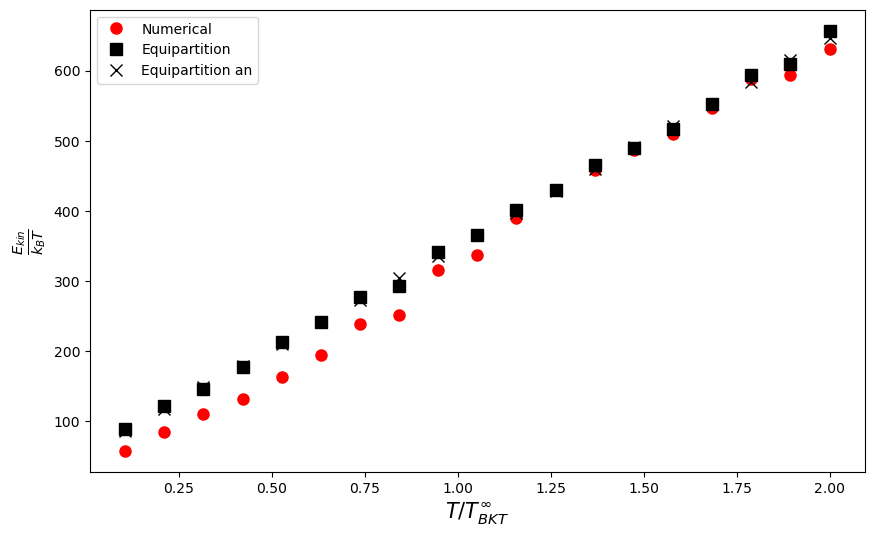

In [23]:
plt.figure(figsize = (10,6))
plt.plot(T_arr/T_BKT, Ek_arr1/(kb*T_arr), "o", ms = 8, color = "red", label = "Numerical")
plt.plot(T_arr/T_BKT, E_equi_arr1/(kb*T_arr), "s", ms = 8, color = "k", label = "Equipartition")
plt.plot(T_arr/T_BKT, E_equi_arr_an1/(kb*T_arr), "x", ms = 8, color = "k", label = "Equipartition an")
plt.xlabel(r"$T/T_{BKT}^{\infty}$", fontsize = 15)
plt.ylabel(r"$\frac{E_{kin}}{k_B T}$", fontsize = 15)
plt.legend()
# plt.savefig("equipartition.png", dpi = 300)
plt.show()

In [25]:
datos = np.column_stack((T_arr, Ek_arr1, E_equi_arr1, E_equi_arr_an1))
np.savetxt('equipartition_an.txt', datos, delimiter=' ')

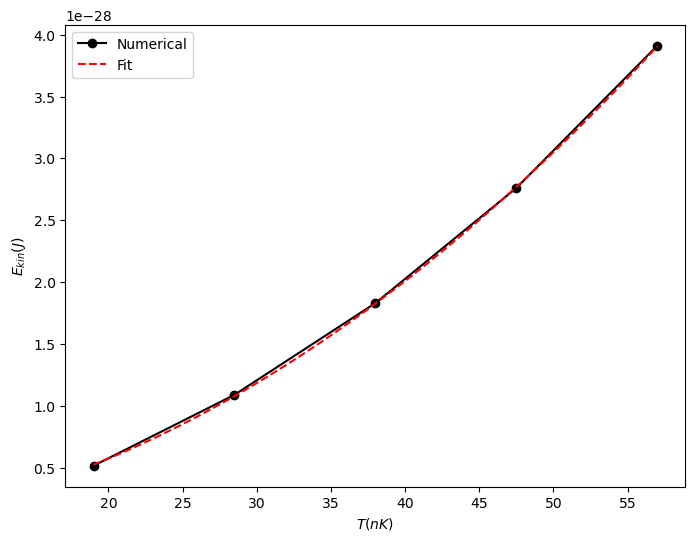

In [93]:
T_arr = np.array(T_arr)
Eplot_arr = np.array(E_equi_arr)
mask_fit = T_arr >= 30e-9 
T_arr_fit = T_arr[mask_fit]
E_fit = Eplot_arr[mask_fit]
E_fit_fit = E_fit/T_arr_fit
coefis = np.polyfit(T_arr_fit, E_fit_fit, 1)
T_plot_fit = np.linspace(T_arr.min(), T_arr.max(), 100)
E_plot_fit = coefis[0]*T_plot_fit**2 + coefis[1]*T_plot_fit
plt.figure(figsize = (8,6))
plt.plot(T_arr/1e-9, Eplot_arr, "o-", color = "k", label = "Numerical")
plt.plot(T_plot_fit/ 1e-9, E_plot_fit, "--", color = "red", label = "Fit")
plt.xlabel(r"$T (nK)$")
plt.ylabel(r"$E_{kin} (J)$")
plt.legend()
plt.savefig("Ekin_limit.png")
plt.show()

In [35]:
%%time

gamma= 0.05
V=0.0
N_tot = int(n0*L_exp**2)
v_arr = []
E_arr = []
Ek_arr1 = []
E_equi_arr1 = []
T = 0.5*T_BKT
ek_recap1 = []
timer1 = []
N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
N_coh = N_tot - N_inc
mu = g*(N_coh)/L_exp**2
E_cut = kb*T*np.log(2) + mu
k_cut = np.sqrt(E_cut*2*m/hbar**2)
k_magnitude = np.sqrt(Kdos)
mask = k_magnitude <= k_cut
psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
for i in range(n_steps):
    if i%int(n_steps/10) == 0:
        print(i/n_steps)
    psi = euler_step_2D(psi)
    timer1.append(i*dt)
    Ek_psi = energy_2D(psi)
    ek_recap1.append(Ek_psi)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
CPU times: total: 3min 15s
Wall time: 3min 15s


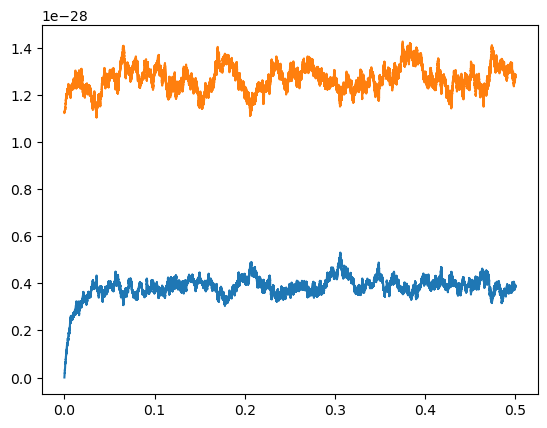

In [45]:
# plt.plot(np.array(timer), ek_recap)
plt.plot(np.array(timer1), ek_recap)
plt.plot(np.array(timer1), np.array(ek_recap1)-np.array(ek_recap))
plt.show()

In [47]:
datos = np.column_stack((timer, ek_recap, ek_recap1))
np.savetxt('energy_conv.txt', datos, delimiter=' ')

In [51]:
%%time

gamma= 0.05
V=0.0
N_tot = int(n0*L_exp**2)
T_arr = np.linspace(0*T_BKT, 7.125e-8, 18)
nk_anal =[]
for T in T_arr:
    # T = 1.5*T_BKT
    N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
    N_coh = N_tot - N_inc
    mu = g*(N_coh)/L_exp**2
    E_cut = kb*T*np.log(2) + mu
    k_cut = np.sqrt(E_cut*2*m/hbar**2)
    k_magnitude = np.sqrt(Kdos)
    mask = k_magnitude <= k_cut
    Nk_modes = np.count_nonzero(mask)
    Nk_modes_analytic = L_exp**2*k_cut**2/(4*np.pi)
    nk_anal.append(Nk_modes_analytic*kb*T)
    print(Nk_modes/Nk_modes_analytic, Nk_modes_analytic*kb*T)
    # break

1.0477290024996955 0.0
1.0225382871361368 5.036509509136839e-30
1.011086602596383 1.3849887322369852e-29
0.9520173084678899 2.6440133439699036e-29
1.000307770326256 4.2807247861124383e-29
1.0157276707163232 6.295123058664592e-29
0.9631796423174998 8.68720816162636e-29
1.0358926026950286 1.1456980094997752e-28
1.004857337507205 1.460373928647718e-28
1.0025779990580155 1.81287974341301e-28
0.9901834821612526 2.203154241219265e-28
1.018452024940587 2.63119742206648e-28
0.9798044452575724 3.0970092859546574e-28
1.0049258268390755 3.600589832883797e-28
0.9955460253958193 4.141939062853899e-28
1.0167365715597338 4.720925806058416e-28
1.0008118314304368 5.337803657456671e-28
0.9865933649511955 5.992450191895888e-28
CPU times: total: 15.6 ms
Wall time: 7.6 ms


In [53]:
datos = np.column_stack((nk_anal))
np.savetxt('equi_an.txt', datos, delimiter=' ')